# 0.- Desciption:

This notebook solves the source update with source that have variable color and with telescopes that implements chromatic aberration.

In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

import quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl



# 1.- Create objects

In [5]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  365*5
my_dt = 1/24 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')

Sat created


In [6]:
alpha_sirio = 101.28  # right ascension
delta_sirio = -16.7161  # declination
base_color, end_color = np.array([-0.1, 0.1])*1e-6   # 1.4 to 1.8 rescaled and centered on 0
mean_color = (end_color+base_color)/2
color_sirio = lambda t: base_color + (t-t_init)/(t_end-t_init) * (end_color-base_color)  
color_sirio2 = lambda t: mean_color

sirio = Source("sirio", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6, func_color=color_sirio, mean_color=mean_color )
sirio2 = Source("sirio2", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6, func_color=color_sirio2, mean_color=mean_color ) #98, -15, 350, -500, -1000, -13.9)
print('Source created')
scanSirio = Scanner() 
print('Scanner created')
sirio.reset()
[sirio.alpha, sirio.delta, sirio.parallax, sirio.mu_alpha_dx, sirio.mu_delta]

Source created
Scanner created


[1.767669466419857,
 -0.29175098309262415,
 1.8384619601354712e-06,
 -6.9464484158848486e-09,
 -1.6246438518145694e-08]

In [7]:
sirio.func_color(10)

-9.890410958904109e-08

In [8]:
np.random.seed(seed=1)  # numpy seed set to increase reproducibility
my_observations = np.random.randint(low=t_init, high=t_end, size=10)
my_observations = np.sort(my_observations)
print('my_observations: {}'.format(my_observations))
my_angles = []
for t_j in my_observations:
    my_angle = sirio.topocentric_angles(gaia, t_j)
    my_angles.append(my_angle)
    print('my_angle: {}'.format(my_angle))
# print('my_angles: {}'.format(my_angles))

my_observations: [ 144  235  715  847  905  960 1061 1096 1669 1791]
my_angle: (1.7676672724216531, 5.991431186095911, -433.42085253781704, 1295999352.742884)
my_angle: (1.7676664227762553, 5.9914313715294005, -601.2669483283647, 1295999390.9912865)
my_angle: (1.7676658624661659, 5.991423099923486, -711.955314540682, 1295997684.8500955)
my_angle: (1.7676628935271883, 5.991419460023302, -1298.4644833115458, 1295996934.0667892)
my_angle: (1.767661233970976, 5.991419375411869, -1626.3071711950702, 1295996916.6144285)
my_angle: (1.7676610709304874, 5.991419520602999, -1658.5155601872657, 1295996946.562249)
my_angle: (1.7676630203375494, 5.991417815366382, -1273.413298345127, 1295996594.831948)
my_angle: (1.7676632499389362, 5.991416592483249, -1228.0559098861327, 1295996342.5941958)
my_angle: (1.767655658659607, 5.991407641392393, -2727.7010568238975, 1295994496.2991745)
my_angle: (1.7676577255101844, 5.991405955222998, -2319.3980154809124, 1295994148.5017712)


In [9]:
for t in my_observations:
    print(sirio.unit_topocentric_function(gaia,t))

[-0.18733571  0.93924054 -0.28763266]
[-0.18733492  0.93924075 -0.28763248]
[-0.18733393  0.93923852 -0.2876404 ]
[-0.18733094  0.93923805 -0.28764389]
[-0.18732938  0.93923834 -0.28764397]
[-0.18732923  0.93923841 -0.28764383]
[-0.18733097  0.93923756 -0.28764547]
[-0.18733111  0.93923717 -0.28764664]
[-0.18732348  0.93923607 -0.28765521]
[-0.18732533  0.93923521 -0.28765682]


# 2.- Solver with color aberration

In [16]:
sirio.set_time(0)
print('alpha:    {}'.format(sirio.alpha))
print('delta:    {}'.format(sirio.delta))
print('parallax: {}'.format(sirio.parallax))
print('mu_alpha: {}'.format(sirio.mu_alpha_dx))
print('mu_delta: {}'.format(sirio.mu_delta))
print('mu_radial:{}'.format(sirio.mu_radial))

alpha:    1.767669466419857
delta:    -0.29175098309262415
parallax: 1.8384619601354712e-06
mu_alpha: -6.9464484158848486e-09
mu_delta: -1.6246438518145694e-08
mu_radial:-8.069677813228491e-09


In [29]:
def noise_calc_sources(s):
    noise = 1e-5
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/100
    s.s_params[3] += s.s_params[3]*0.01
    s.s_params[4] += s.s_params[4]*0.01

In [32]:

# initialize the parameters

deviated_angle = 10 / 360 * (2*np.pi)  # degrees converted in radians

s = Calc_source(obs_times=my_observations, source=sirio, mean_color=sirio.mean_color)
s2 =  Calc_source(obs_times=my_observations, source=sirio2, mean_color=sirio2.mean_color)
noise_calc_sources(s)
noise_calc_sources(s2)

Solver = Agis(gaia, [s, s2], [sirio, sirio2], updating='source', degree_error=1)

In [42]:
Solver.verbose=False
Solver.reset_iterations()
Solver.iterate(10, verbosity=2)

Not resetting everything! Call again the solver instead
***** Iteration: 1 *****
Error before iteration: 2.026271090538291e-17
Error after iteration: 1.9938438813287205e-17
***** Iteration: 2 *****
Error before iteration: 1.9938438813287205e-17
Error after iteration: 2.0249601695556972e-17
***** Iteration: 3 *****
Error before iteration: 2.0249601695556972e-17
Error after iteration: 2.0220637167555684e-17
***** Iteration: 4 *****
Error before iteration: 2.0220637167555684e-17
Error after iteration: 2.0086549363095364e-17
***** Iteration: 5 *****
Error before iteration: 2.0086549363095364e-17
Error after iteration: 2.006859973191066e-17
***** Iteration: 6 *****
Error before iteration: 2.006859973191066e-17
Error after iteration: 1.9976806439855483e-17
***** Iteration: 7 *****
Error before iteration: 1.9976806439855483e-17
Error after iteration: 2.0157372250103523e-17
***** Iteration: 8 *****
Error before iteration: 2.0157372250103523e-17
Error after iteration: 2.0139697216412777e-17
***

# 3.- Plot results

'running'

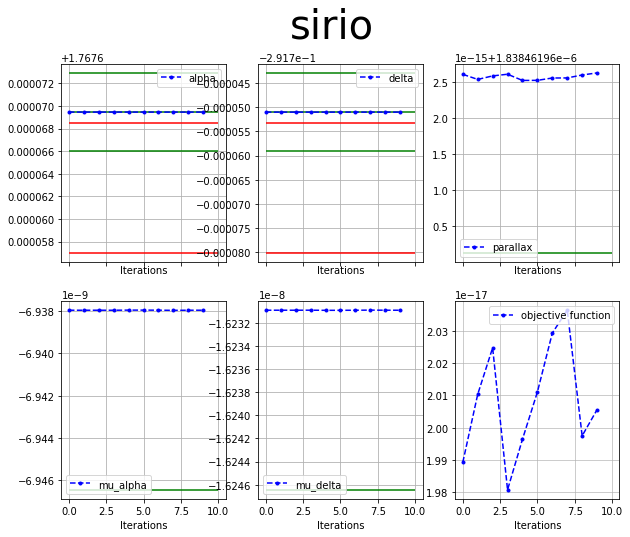

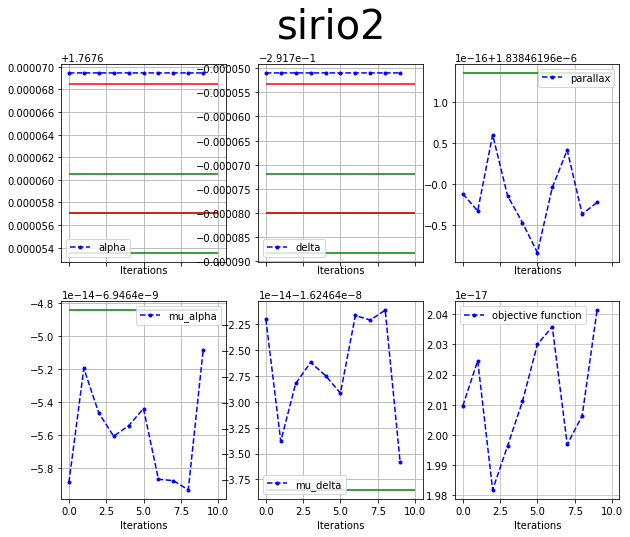

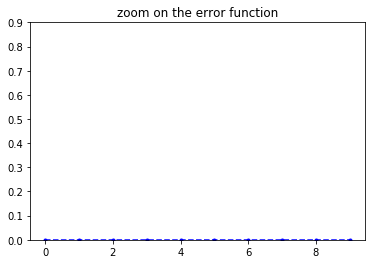

In [40]:
titles = ['sirio', 'sirio2']

for source_index in range(len(Solver.calc_sources)):
    calc_source = Solver.calc_sources[source_index]
    real_source = Solver.real_sources[source_index]
    
    source_params = np.array(calc_source.s_old)
    fig, axs = plt.subplots(2, 3, figsize=(10,8), sharex='all')
    
    fig.suptitle(titles[source_index], fontsize=40)
    
    num_iters = len(calc_source.errors)
    labels = ['alpha', 'delta', 'parallax', 'mu_alpha', 'mu_delta']
    sirio.set_time(0)
    observed = [real_source.alpha, real_source.delta, real_source.parallax, real_source.mu_alpha_dx, real_source.mu_delta]

    alpha_list = []
    delta_list = []
    for t_L in my_observations:
        real_source.set_time(float(t_L))
        alpha_list.append(real_source.alpha)
        delta_list.append(real_source.delta)
    std_alpha = np.std(alpha_list)
    std_delta = np.std(delta_list)
    min_alpha, max_alpha = (np.min(alpha_list), np.max(alpha_list))
    min_delta, max_delta = (np.min(delta_list), np.max(delta_list))

    for i, x in enumerate(source_params.T):
        if i<3:
            ax = axs[0, i]
        else:
            ax = axs[1, i-3]
        ax.plot(x, 'b--.', label=labels[i])
        ax.hlines(observed[i], xmin=0, xmax=num_iters, color='g')
        ax.grid()
        ax.set_label('labels[i]')
        ax.set_xlabel('Iterations')
        ax.legend()

    axs[0,0].hlines(observed[0]+std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(observed[0]-std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(min_alpha, xmin=0, xmax=num_iters, color='r')
    axs[0,0].hlines(max_alpha, xmin=0, xmax=num_iters, color='r')

    axs[0,1].hlines(observed[1]+std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(observed[1]-std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(min_delta, xmin=0, xmax=num_iters, color='r')
    axs[0,1].hlines(max_delta, xmin=0, xmax=num_iters, color='r')

    # plot evolution of the error
    ax = axs[-1, -1] 
    ax.plot(calc_source.errors, 'b--.', label='objective function')
    # ax.set_xlim((0, num_iters))
    ax.set_xlabel('Iterations')
    ax.grid(alpha= 0.8)  
    ax.legend()


    fig.savefig('./figures/tmp/errors')

f3 = plt.figure()
plt.title('zoom on the error function')
plt.plot(calc_source.errors, 'b--.', label='objective function')
plt.ylim((0,0.9))
'running'

**Here below we should have:**
* real_source_1 = real_source_2

[-5.34650590e-09 -1.83204391e-08  2.47385247e-15  8.49193607e-12
  1.55068167e-11]


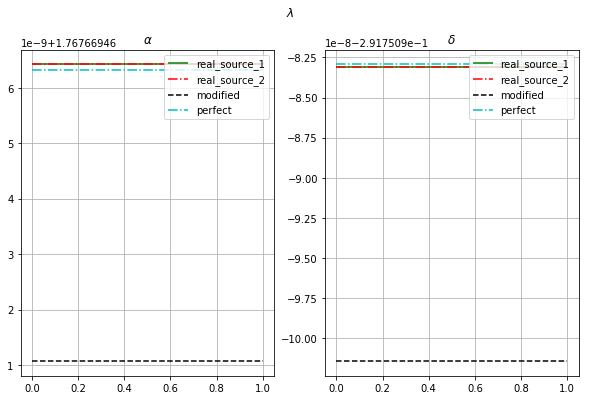

(Text(0.5, 0.98, '$\\lambda$'), None)

In [43]:
print(Solver.calc_sources[0].s_params - Solver.real_sources[0].get_parameters()[0:5])

fig, axs = plt.subplots(1, 2, figsize=(10,6))
titles = ['$\\alpha$', '$\\delta$']
for i, ax in enumerate(axs):
    ax.hlines(Solver.real_sources[0].get_parameters()[i], xmin=0, xmax=1, color='g', linestyles='solid', label='real_source_1')
    ax.hlines(Solver.real_sources[1].get_parameters()[i], xmin=0, xmax=1, color='r', linestyles='dashdot', label='real_source_2')
    ax.hlines(Solver.calc_sources[0].s_params[i], xmin=0, xmax=1, color='k', linestyles='dashed', label='modified')
    ax.hlines(Solver.calc_sources[1].s_params[i], xmin=0, xmax=1, color='c', linestyles='dashdot', label='perfect')
    
    ax.set_title(titles[i])
    ax.grid(), ax.legend()


plt.suptitle('$\\lambda$'), plt.show()

# 5.- -- Other Test --

### 5.1 - - test : Test rotations --

In [44]:
Su = np.array([1, 0, 0])
Cu = np.array([1,2,3])
Cu = Cu/np.linalg.norm(Cu)
print('Cu:', Cu)
[Cu[0], 0, 0]

Cu: [0.26726124 0.53452248 0.80178373]


[0.2672612419124244, 0, 0]

In [45]:
Cu_xy = helpers.normalize(np.array([Cu[0], Cu[1], 0]))
print('Cu_xy',Cu_xy)


v1, a1 = helpers.get_rotation_vector_and_angle(Cu_xy, Su)
q1 = quaternion.from_rotation_vector(v1*a1)
Su_xy = ft.rotate_by_quaternion(q1.inverse(), Su)

v2, a2 = helpers.get_rotation_vector_and_angle(Cu, Su_xy)
print('v2',v2)
print('Su_xy',Su_xy)
q2 = quaternion.from_rotation_vector(v2*a2)
deviated_angle = np.pi/6
q23 = quaternion.from_rotation_vector(v2*(a2+deviated_angle))
AA = ft.rotate_by_quaternion(q23.inverse(), Su_xy)
BB = ft.rotate_by_quaternion((q1*q23).inverse(), Su)

Cu_bis = ft.rotate_by_quaternion(q2.inverse(), Su_xy)
print('Cu_bis',Cu_bis)

ft.rotate_by_quaternion((q1*q2).inverse(), Su)

print(deviated_angle)
_, what_I_want = helpers.get_rotation_vector_and_angle(AA, Cu)
print(what_I_want)
print(AA,'\n', BB)

Cu_xy [0.4472136  0.89442719 0.        ]
v2 [-8.94427191e-01  4.47213595e-01 -3.46172848e-17]
Su_xy [0.4472136  0.89442719 0.        ]
Cu_bis [0.26726124 0.53452248 0.80178373]
0.5235987755982988
0.5235987755982985
[0.05217073 0.10434147 0.99317223] 
 [0.05217073 0.10434147 0.99317223]


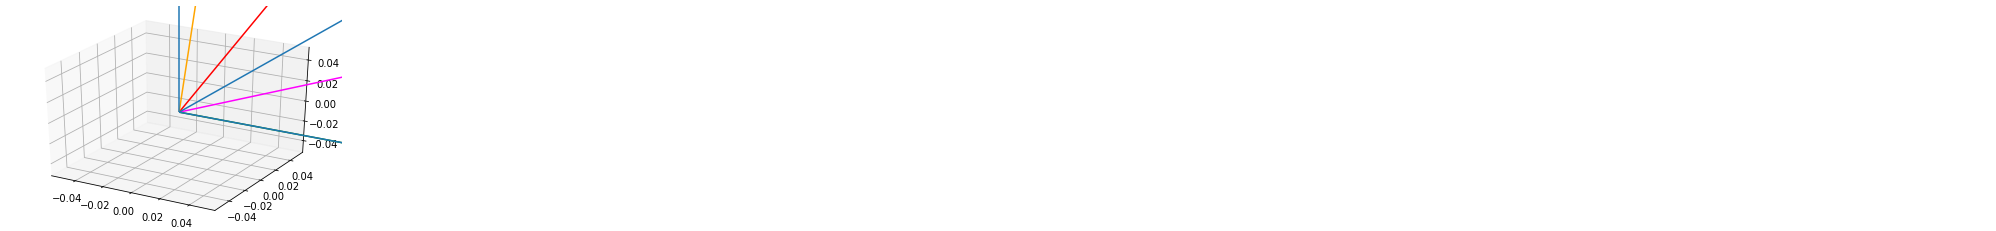

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

p0 = [1, 0, 0]
p1 = [0, 1, 0]
p2 = [0,0, 1]

origin = [0,0,0]
X, Y, Z = zip(origin,origin,origin) 
U, V, W = zip(p0,p1,p2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X,Y,Z,U,V,W,arrow_length_ratio=0.1)

U, V, W = zip(Cu,Su,p2)
ax.quiver(0,0,0,Cu[0],Cu[1],Cu[2],arrow_length_ratio=0.1, color='red') 
ax.quiver(0,0,0,Su[0],Su[1],Su[2],arrow_length_ratio=0.1, color='green')
ax.quiver(0,0,0,Su_xy[0],Su_xy[1],Su_xy[2],arrow_length_ratio=0.1, color='magenta')
ax.quiver(0,0,0,BB[0], BB[1], BB[2],arrow_length_ratio=0.1, color='orange')
plt.show()